# Predictive model and feature importance for state level homelessness

*CS109A/AC209A final project: Group 8*

**Contact info:** Renhao Luo (renhao_luo@hms.harvard.edu), Ziqi Wang (ziqiwang@hms.harvard.edu), Shun Li (shunli@g.harvard.edu), Linzi Yu (linzi_yu@hms.harvard.edu), Senmiao Sun (sun_senmiao@g.harvard.edu)

**Table of contents**<a id='toc0_'></a>    
- [**Introduction**: Predictive model and feature importance for state level homelessness](#toc1_)    
- [**Datasets and Exploratory Data Analysis (EDA)**](#toc2_)    
  - [Homeless and housing price](#toc2_1_)    
  - [Economic and political party dataset](#toc2_2_)
  - [Politics Dataset](#toc2_3_)    
  - [Economy Dataset](#toc2_4_)    
  - [Merge Datasets](#toc2_5_)    
  - [Missing Values](#toc2_6_)    
  - [Correlation between each variable and homeless count](#toc2_7_)    
  - [Choropleth graph of homeless count by state](#toc2_8_)    
  - [Choropleth graph of political party by state](#toc2_9_)    
  - [Choropleth graph of average salary by state](#toc2_10_)    
  - [Choropleth graph of per capita net earning by state](#toc2_11_)    
  - [Choropleth graph of Total Number of Jobs by state](#toc2_12_)    
- [Model Development and Evaluation](#toc3_)    
  - [Impute missing data](#toc3_1_)    
  - [Plotting](#toc3_2_)    
- [Standardize the data](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Introduction](#toc1_)

By recent estimates, over 600,000 Americans live in some state of homelessness each year. In recent decades, the quality of available data on homelessness in the United States has greatly improved, but there is still a long way to go. 

In this project, we combined different state-level statistics (housing, income, and political involvement) that are related to homelessness, and build multiple regression models for predicting the number homeless people in the United States. In addition, we discussed about the most important predictors for the machine learning models. In a word, we aim to enhance our understanding of the causes of homelessness from different perspectives by interpreting the most important features highlighted by the machine learning models.

The state level homeless data we used were from Kaggle (https://www.kaggle.com/code/adamschroeder/homelessness-comparison-between-states/data), which contains the data collected by the US Department of Housing and Urban Development (HUD). 

For model prediction, we also included features from these datasets:
- Zillow Housing Data: https://www.kaggle.com/datasets/zillow/zecon
- US Economics Profile by county: https://www.kaggle.com/datasets/davidbroberts/us-economic-profile-by-county?resource=download&select=profile_by_county_1969_2019.csv
- County Presidential Election Returns 2000-2020: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ






In [1]:
!pip install plotly

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
!ls ../data

2007-2016-Homelessnewss-USA.csv
README.md
State_time_series.csv
countypres_2000-2020.csv
df_econ_sub.csv
homeless_count_Econ_Politics_by_state.csv
homeless_count_with_housing_price_by_state.csv
profile_by_county_1969_2019.csv
scaled_X_test.csv
scaled_X_train.csv
scaled_y_test.csv
scaled_y_train.csv


# <a id='toc2_'></a>[Datasets and Exploratory Data Analysis (EDA)](#toc2_)

## <a id='toc2_1_'></a>[Homeless and housing price](#toc2_1_)

Here, we combine the number of homeless people in each state with the average price of each property sold in each state for year 2008 and 2016. Then we perform EDA analysis on the predictors. 

In [3]:
homeless_df = pd.read_csv("../data/2007-2016-Homelessnewss-USA.csv")
homeless_df

,Year,State,CoC Number,CoC Name,Measures,Count
0,1/1/07,AK,AK-500,Anchorage CoC,Chronically Homeless Individuals,224
1,1/1/07,AK,AK-500,Anchorage CoC,Homeless Individuals,696
2,1/1/07,AK,AK-500,Anchorage CoC,Homeless People in Families,278
3,1/1/07,AK,AK-500,Anchorage CoC,Sheltered Chronically Homeless Individuals,187
4,1/1/07,AK,AK-500,Anchorage CoC,Sheltered Homeless,842
...,...,...,...,...,...,...
86524,1/1/16,WY,WY-500,Wyoming Statewide CoC,Unsheltered Homeless Unaccompanied Youth (Unde...,7
86525,1/1/16,WY,WY-500,Wyoming Statewide CoC,Unsheltered Homeless Veterans,31
86526,1/1/16,WY,WY-500,Wyoming Statewide CoC,Unsheltered Parenting Youth (Under 25),3
86527,1/1/16,WY,WY-500,Wyoming Statewide CoC,Unsheltered Parenting Youth Age 18-24,3


In [4]:
# extract the year and add a new column to the dataframe
homeless_df['Year_only'] = pd.DatetimeIndex(homeless_df['Year']).year 

# subset the homeless data to only contain data from year 2008 and 2016
homeless_df_subset_08_16 = homeless_df[homeless_df['Year_only'].isin([2008, 2016])]
homeless_df_subset_08_16

,Year,State,CoC Number,CoC Name,Measures,Count,Year_only
4824,1/1/08,AK,AK-500,Anchorage CoC,Chronically Homeless Individuals,300,2008
4825,1/1/08,AK,AK-500,Anchorage CoC,Homeless Individuals,695,2008
4826,1/1/08,AK,AK-500,Anchorage CoC,Homeless People in Families,328,2008
4827,1/1/08,AK,AK-500,Anchorage CoC,Sheltered Chronically Homeless Individuals,239,2008
4828,1/1/08,AK,AK-500,Anchorage CoC,Sheltered Homeless,921,2008
...,...,...,...,...,...,...,...
86524,1/1/16,WY,WY-500,Wyoming Statewide CoC,Unsheltered Homeless Unaccompanied Youth (Unde...,7,2016
86525,1/1/16,WY,WY-500,Wyoming Statewide CoC,Unsheltered Homeless Veterans,31,2016
86526,1/1/16,WY,WY-500,Wyoming Statewide CoC,Unsheltered Parenting Youth (Under 25),3,2016
86527,1/1/16,WY,WY-500,Wyoming Statewide CoC,Unsheltered Parenting Youth Age 18-24,3,2016


In [5]:
# describe the dataframe
homeless_df_subset_08_16.describe()

,Count,Year_only
count,21648.000000,21648.000000
mean,260.139320,2014.239468
std,1448.592168,3.314407
min,0.000000,2008.000000
25%,2.000000,2016.000000
50%,25.000000,2016.000000
75%,153.000000,2016.000000
max,73523.000000,2016.000000


Note: The homeless data acquired from the U.S. Department of Housing and Urban Development uses the Continuums of Care (CoC) number, which divides each state into different geographic area. However, it does not necessarily match with the known zip code or county boundaries, which makes it hard to join this data with other county level data. Therefore, we first explore the data at states level. 

In [6]:
# Convert the count to numeric
homeless_df_subset_08_16["Count"] = pd.to_numeric(homeless_df_subset_08_16["Count"])
homeless_df_subset_08_16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21648 entries, 4824 to 86528
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        21648 non-null  object
 1   State       21648 non-null  object
 2   CoC Number  21648 non-null  object
 3   CoC Name    21648 non-null  object
 4   Measures    21648 non-null  object
 5   Count       21648 non-null  int64 
 6   Year_only   21648 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.3+ MB


/var/folders/sd/hl_8_g39189b03rq7tsq0ty00000gn/T/ipykernel_55887/831592487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homeless_df_subset_08_16["Count"] = pd.to_numeric(homeless_df_subset_08_16["Count"])


In [7]:
# first aggregate the data into state level
homeless_df_subset_08_16_for_join = homeless_df_subset_08_16.groupby(["Year_only","State"])["Count"].sum().reset_index()
homeless_df_subset_08_16_for_join.columns = ["Year_only", "state_abbrev", "homeless_count"]
# homeless_df_subset_08_16_for_join.to_csv("../data/homeless_people_by_state.csv", index=False)
homeless_df_subset_08_16_for_join

,Year_only,state_abbrev,homeless_count
0,2008,AK,7462
1,2008,AL,23652
2,2008,AR,14806
3,2008,AZ,56146
4,2008,CA,626632
...,...,...,...
103,2016,VT,5762
104,2016,WA,103862
105,2016,WI,27656
106,2016,WV,7020


In [8]:
# convert the state name to abbrevation

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "WestVirginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "DistrictofColumbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}

In [9]:
housing_price_df2 = pd.read_csv("../data/State_time_series.csv")
housing_price_df2

,Date,RegionName,DaysOnZillow_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
0,1996-04-30,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45600.0,99500.0,79500.0,79000.0,140200.0,NaN,NaN,NaN,NaN,NaN
1,1996-04-30,Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67100.0,78900.0,103600.0,107500.0,168700.0,NaN,NaN,NaN,NaN,NaN
2,1996-04-30,Arkansas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38400.0,70300.0,64400.0,64500.0,115200.0,NaN,NaN,NaN,NaN,NaN
3,1996-04-30,California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95100.0,136100.0,157900.0,162000.0,270600.0,NaN,NaN,NaN,NaN,NaN
4,1996-04-30,Colorado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,82700.0,99400.0,128100.0,133600.0,209300.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13207,2017-12-31,Virginia,NaN,39599.0,36664.0,242.105263,146.157362,143.816452,147.329650,153.763978,...,133500.0,291300.0,246200.0,237300.0,492700.0,1538.0,1500.0,0.948,1738.0,1441.0
13208,2017-12-31,Washington,NaN,17918.0,15109.0,304.291151,220.017256,195.881979,188.990826,201.271186,...,208200.0,337600.0,351300.0,352800.0,662700.0,1842.0,1803.0,1.132,1690.0,1828.0
13209,2017-12-31,WestVirginia,NaN,9800.0,9422.0,119.723429,77.764277,89.272003,93.071172,88.122881,...,63800.0,115100.0,103500.0,103300.0,174300.0,858.0,858.0,0.674,846.0,858.0
13210,2017-12-31,Wisconsin,NaN,27273.0,23370.0,145.664583,129.727412,127.136334,116.753927,95.573529,...,107200.0,158700.0,169300.0,170200.0,280600.0,1179.0,1153.0,0.920,1068.0,1163.0


In [10]:
# extract the year of the sold date and add a new column to the dataframe
housing_price_df2['Year_only'] = pd.DatetimeIndex(housing_price_df2['Date']).year 

# subset the housing price data to 2008 and 2016
housing_price2_subset_08_16 = housing_price_df2[housing_price_df2['Year_only'].isin([2008, 2016])]

# convert state full name to abbreviation
housing_price2_subset_08_16["state_abbrev"] = housing_price2_subset_08_16["RegionName"].map(us_state_to_abbrev)

housing_price2_subset_08_16_join = housing_price2_subset_08_16.groupby(["Year_only","state_abbrev"])[["Sale_Prices", "MedianListingPricePerSqft_1Bedroom", "MedianListingPricePerSqft_2Bedroom", "MedianListingPricePerSqft_3Bedroom", "MedianListingPricePerSqft_4Bedroom", "MedianListingPricePerSqft_5BedroomOrMore"]].mean().reset_index()#.to_csv("Housing_data.csv", index=False)

# join final dataframe
final_dataframe = pd.merge(homeless_df_subset_08_16_for_join, housing_price2_subset_08_16_join, how="left", left_on=["Year_only", "state_abbrev"], right_on=["Year_only", "state_abbrev"])
final_dataframe

/var/folders/sd/hl_8_g39189b03rq7tsq0ty00000gn/T/ipykernel_55887/502423884.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_price2_subset_08_16["state_abbrev"] = housing_price2_subset_08_16["RegionName"].map(us_state_to_abbrev)


,Year_only,state_abbrev,homeless_count,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,2008,AK,7462,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,AL,23652,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,AR,14806,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,AZ,56146,190750.000000,NaN,NaN,NaN,NaN,NaN
4,2008,CA,626632,314980.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
103,2016,VT,5762,NaN,152.405230,146.871426,140.774273,138.816947,121.721618
104,2016,WA,103862,294916.666667,270.179354,192.746052,174.273438,174.817988,183.988193
105,2016,WI,27656,163283.333333,139.400275,119.647646,119.108371,113.191737,98.356697
106,2016,WV,7020,140341.666667,111.100490,81.744695,90.590600,93.592909,89.201195


In [11]:
# save the final housing dataframe
# final_dataframe.to_csv("../data/homeless_count_with_housing_price_by_state.csv", index=False)

In [12]:
# set font
font = {'size'   : 16}
plt.rc('font', **font)

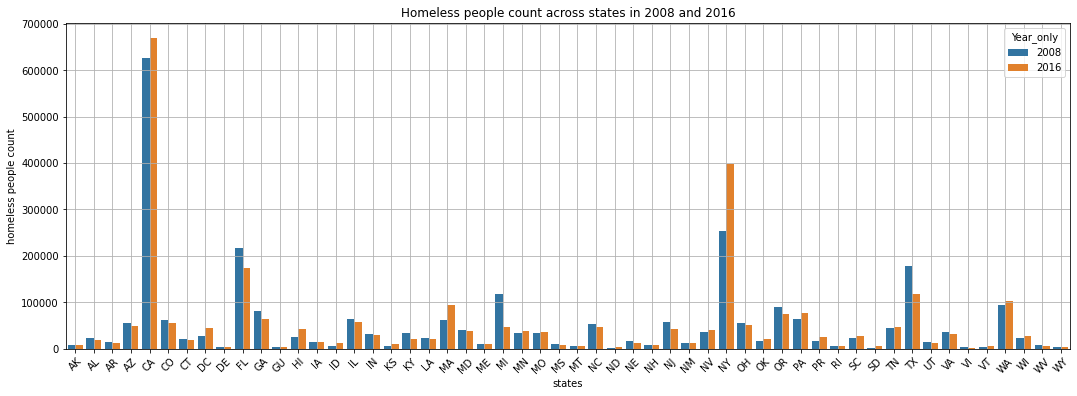

In [13]:
# plot the number of homeless people per state
plt.figure(figsize=(18,6))
sns.barplot(y='homeless_count', x='state_abbrev', hue="Year_only", data=final_dataframe)
plt.ylabel('homeless people count')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Homeless people count across states in 2008 and 2016')
plt.grid();

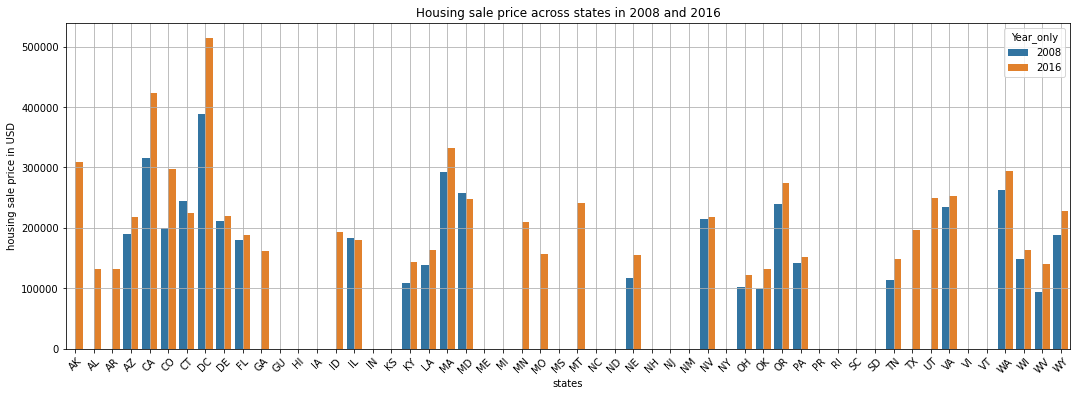

In [14]:
# plot the number of homeless people per state
plt.figure(figsize=(18,6))
sns.barplot(y='Sale_Prices', x='state_abbrev', hue="Year_only", data=final_dataframe)
plt.ylabel('housing sale price in USD')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Housing sale price across states in 2008 and 2016')
plt.grid();

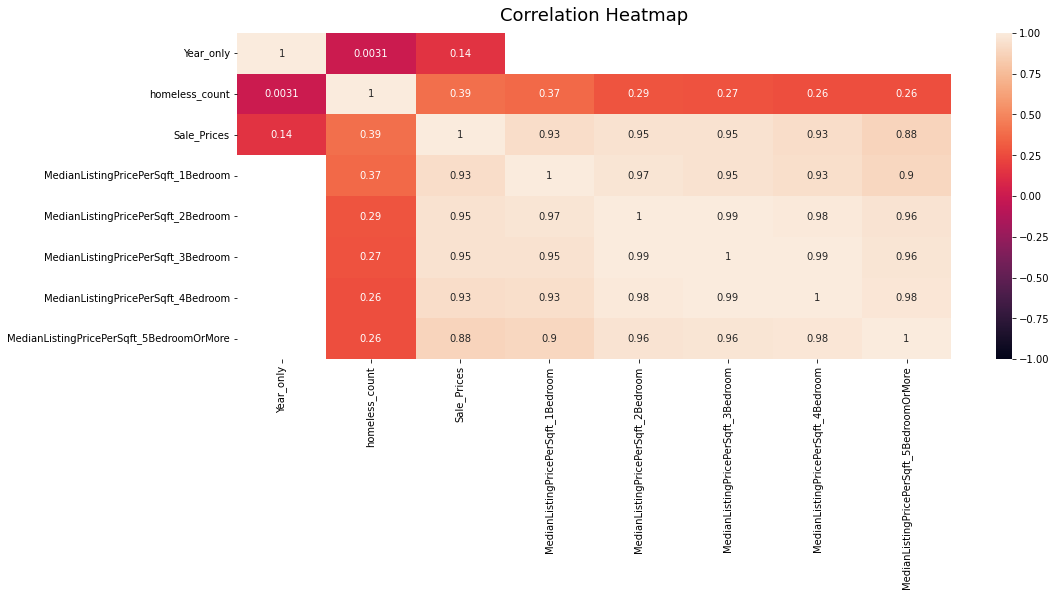

In [15]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(final_dataframe.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

## <a id='toc2_2_'></a>[Economic and political party dataset](#toc0_)

In [16]:
!ls ../data/

2007-2016-Homelessnewss-USA.csv
README.md
State_time_series.csv
countypres_2000-2020.csv
df_econ_sub.csv
homeless_count_Econ_Politics_by_state.csv
homeless_count_with_housing_price_by_state.csv
profile_by_county_1969_2019.csv
scaled_X_test.csv
scaled_X_train.csv
scaled_y_test.csv
scaled_y_train.csv


In [17]:
df_homeless = pd.read_csv("../data/2007-2016-Homelessnewss-USA.csv")
df_homeless

df_politics = pd.read_csv("../data/countypres_2000-2020.csv")
df_politics

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL
3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL
72613,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,20220315,TOTAL
72614,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46,3560,20220315,TOTAL
72615,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,OTHER,OTHER,47,3560,20220315,TOTAL


In [18]:
df_econ = pd.read_csv("../data/profile_by_county_1969_2019.csv", encoding='latin-1')
df_econ

/var/folders/sd/hl_8_g39189b03rq7tsq0ty00000gn/T/ipykernel_55887/2483043623.py:1: DtypeWarning: Columns (2,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_econ = pd.read_csv("../data/profile_by_county_1969_2019.csv", encoding='latin-1')


,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"""00000""",United States,,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,791229000,855525000,...,12541995000,13315478000,13998383000,14175503000,14982715000,15717140000,16151881000,16937582000,17839255000,18542262000
1,"""00000""",United States,,CAINC30,45.0,...,Net earnings by place of residence,Thousands of dollars,609767000,647228000,...,8044221000,8531667000,8956340000,9132669000,9539185000,9915088000,10145493000,10626821000,11167886000,11667012000
2,"""00000""",United States,,CAINC30,50.0,...,Personal current transfer receipts,Thousands of dollars,62322000,74733000,...,2325117000,2358654000,2362988000,2424297000,2541510000,2685370000,2776746000,2855049000,2970254000,3125174000
3,"""00000""",United States,,CAINC30,60.0,...,Income maintenance benefits 1/,Thousands of dollars,7275000,9897000,...,256034000,264137000,267614000,271171000,270971000,273685000,270259000,268468000,260380000,268682000
4,"""00000""",United States,,CAINC30,70.0,...,Unemployment insurance compensation,Thousands of dollars,2328000,4200000,...,139715000,107871000,84439000,63049000,35787000,32860000,32482000,30756000,28302000,28075000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99137,"""98000""",Far West,8.0,CAINC30,310.0,...,Average nonfarm proprietors' income,Dollars,7216.0,7201.0,...,33289.0,34288.0,37835.0,37052.0,36527.0,36406.0,37290.0,37791.0,38275.0,38651.0
99138,Note: See the included footnote file.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99139,CAINC30: Economic Profile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99140,"Last updated: November 17, 2020-- new statisti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_homeless['Year_only'] = pd.DatetimeIndex(df_homeless['Year']).year 
df_homeless_sub = df_homeless.query("Year_only == 2008 or Year_only == 2016")
# df_homeless_sub['Count'] = df_homeless_sub['Count'].str.replace(',', '').astype(float)

df_homeless_sub.describe()

,Count,Year_only
count,21648.000000,21648.000000
mean,260.139320,2014.239468
std,1448.592168,3.314407
min,0.000000,2008.000000
25%,2.000000,2016.000000
50%,25.000000,2016.000000
75%,153.000000,2016.000000
max,73523.000000,2016.000000


In [20]:
df_homeless_sub = df_homeless_sub.groupby(["Year_only","State"])["Count"].sum().reset_index()
df_homeless_sub.columns = ["year", "state_abbrev", "homeless_count"]
df_homeless_sub

,year,state_abbrev,homeless_count
0,2008,AK,7462
1,2008,AL,23652
2,2008,AR,14806
3,2008,AZ,56146
4,2008,CA,626632
...,...,...,...
103,2016,VT,5762
104,2016,WA,103862
105,2016,WI,27656
106,2016,WV,7020


## <a id='toc2_3_'></a>[Politics Dataset](#toc0_)

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ

In [21]:
df_politics_sub = (
df_politics.query("year == 2008 or year == 2016")
            .query("party == 'DEMOCRAT'")
            .rename(columns = {"state_po":"state_abbrev"})
            .groupby(["year", "state_abbrev"]).sum().reset_index()
)[['year', 'state_abbrev', 'candidatevotes', 'totalvotes']]

df_politics_sub

,year,state_abbrev,candidatevotes,totalvotes
0,2008,AK,123594,326197
1,2008,AL,813479,2099819
2,2008,AR,422310,1086617
3,2008,AZ,1034707,2293475
4,2008,CA,8274473,13561900
...,...,...,...,...
97,2016,VT,178573,315077
98,2016,WA,1742718,3209214
99,2016,WI,1381823,2975753
100,2016,WV,188794,713051


In [22]:
df_politics_sub['democrat_perc'] = df_politics_sub['candidatevotes']/df_politics_sub['totalvotes'] * 100

df_politics_sub = df_politics_sub[['year', 'state_abbrev', 'democrat_perc']]
df_politics_sub


,year,state_abbrev,democrat_perc
0,2008,AK,37.889374
1,2008,AL,38.740434
2,2008,AR,38.864660
3,2008,AZ,45.115251
4,2008,CA,61.012638
...,...,...,...
97,2016,VT,56.675987
98,2016,WA,54.303577
99,2016,WI,46.436079
100,2016,WV,26.476928


## <a id='toc2_4_'></a>[Economy Dataset](#toc0_)

https://www.kaggle.com/datasets/davidbroberts/us-economic-profile-by-county?resource=download&select=profile_by_county_1969_2019.csv

In [23]:
states_FIPS = ['01000', '02000', '03000', '04000', '05000', '06000', '07000', '08000', '09000']
for i in range(10, 57):
    fips = str(i)+'000'
    states_FIPS.append(fips)

df_econ['GeoFIPS'] = df_econ['GeoFIPS'].str.slice(2,7)

econ_cols = [' Per capita personal income 4/', ' Per capita net earnings 4/', 'Total employment (number of jobs)', ' Average wages and salaries']

In [24]:
df_econ_sub = (df_econ[['GeoFIPS', 'GeoName', 'Description', '2008', '2016']]
                 .query("GeoFIPS in @states_FIPS")
                 .query("Description in @econ_cols")
                 .assign(state_abbrev = df_econ['GeoName'].map(us_state_to_abbrev))
                 .drop(columns = ['GeoFIPS', 'GeoName'])               
                )

df_econ_sub

,Description,2008,2016,state_abbrev
39,Per capita personal income 4/,33353,39536,AL
40,Per capita net earnings 4/,20229,23180,AL
54,Total employment (number of jobs),2582591,2619796,AL
60,Average wages and salaries,38138,44187,AL
2147,Per capita personal income 4/,47749,56302,AK
...,...,...,...,...
95881,Average wages and salaries,39662,46551,WI
98154,Per capita personal income 4/,48593,54168,WY
98155,Per capita net earnings 4/,28776,30753,WY
98169,Total employment (number of jobs),398969,398271,WY


In [25]:
df_econ_sub_08 = (df_econ_sub.drop(columns = ['2016'])
                             .assign(year = 2008)
                 )
df_econ_sub_16 = (df_econ_sub.drop(columns = ['2008'])
                             .assign(year = 2016)
                 )


In [26]:
df_econ_sub_08

,Description,2008,state_abbrev,year
39,Per capita personal income 4/,33353,AL,2008
40,Per capita net earnings 4/,20229,AL,2008
54,Total employment (number of jobs),2582591,AL,2008
60,Average wages and salaries,38138,AL,2008
2147,Per capita personal income 4/,47749,AK,2008
...,...,...,...,...
95881,Average wages and salaries,39662,WI,2008
98154,Per capita personal income 4/,48593,WY,2008
98155,Per capita net earnings 4/,28776,WY,2008
98169,Total employment (number of jobs),398969,WY,2008


In [27]:
df_econ_sub_08 = (df_econ_sub_08.pivot(index=['year', 'state_abbrev'], columns='Description', values='2008').reset_index()
                                .rename(columns = {' Average wages and salaries':"AvgSalary", ' Per capita net earnings 4/':"PerCapNetEarning", ' Per capita personal income 4/':"PerCapNetIncome", "Total employment (number of jobs)":"TotalNumJobs"})
                 )

df_econ_sub_16 = (df_econ_sub_16.pivot(index=['year', 'state_abbrev'], columns='Description', values='2016').reset_index()
                                .rename(columns = {' Average wages and salaries':"AvgSalary", ' Per capita net earnings 4/':"PerCapNetEarning", ' Per capita personal income 4/':"PerCapNetIncome", "Total employment (number of jobs)":"TotalNumJobs"})
                 )


ValueError: Index contains duplicate entries, cannot reshape

In [28]:
df_econ_sub = pd.concat([df_econ_sub_08, df_econ_sub_16])
df_econ_sub

,Description,2008,state_abbrev,year,2016
39,Per capita personal income 4/,33353,AL,2008,NaN
40,Per capita net earnings 4/,20229,AL,2008,NaN
54,Total employment (number of jobs),2582591,AL,2008,NaN
60,Average wages and salaries,38138,AL,2008,NaN
2147,Per capita personal income 4/,47749,AK,2008,NaN
...,...,...,...,...,...
95881,Average wages and salaries,NaN,WI,2016,46551
98154,Per capita personal income 4/,NaN,WY,2016,54168
98155,Per capita net earnings 4/,NaN,WY,2016,30753
98169,Total employment (number of jobs),NaN,WY,2016,398271


## <a id='toc2_5_'></a>[Merge Datasets](#toc0_)

In [29]:
df_econ_politcs = (df_homeless_sub.merge(df_politics_sub, how = "left", on = ['year', 'state_abbrev'])
                                  .merge(df_econ_sub, how = "left", on = ['year', 'state_abbrev'])
                  )
df_econ_politcs

,year,state_abbrev,homeless_count,democrat_perc,Description,2008,2016
0,2008,AK,7462,37.889374,Per capita personal income 4/,47749,NaN
1,2008,AK,7462,37.889374,Per capita net earnings 4/,31586,NaN
2,2008,AK,7462,37.889374,Total employment (number of jobs),443538,NaN
3,2008,AK,7462,37.889374,Average wages and salaries,48527,NaN
4,2008,AL,23652,38.740434,Per capita personal income 4/,33353,NaN
...,...,...,...,...,...,...,...
397,2016,WV,7020,26.476928,NaN,NaN,NaN
398,2016,WY,4184,21.877357,Per capita personal income 4/,NaN,54168
399,2016,WY,4184,21.877357,Per capita net earnings 4/,NaN,30753
400,2016,WY,4184,21.877357,Total employment (number of jobs),NaN,398271


In [ ]:
# df_econ_politcs.to_csv("../data/homeless_count_Econ_Politics_by_state.csv", index=False)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

## <a id='toc2_6_'></a>[Missing Values](#toc0_)

Some states such as Guam, American Samoa, Northern Mariana Islands, Puerto Rico, US Minor Outlying Islands, Virgin Islands have missing values. 

In [31]:
df_econ_politcs = pd.read_csv("../data/homeless_count_Econ_Politics_by_state.csv")

In [32]:
df_econ_politcs.isna().sum()

year                0
state_abbrev        0
homeless_count      0
democrat_perc       6
AvgSalary           6
PerCapNetEarning    6
PerCapNetIncome     6
TotalNumJobs        6
dtype: int64

In [33]:
df_econ_politcs["AvgSalary"] = pd.to_numeric(df_econ_politcs["AvgSalary"])
df_econ_politcs["PerCapNetEarning"] = pd.to_numeric(df_econ_politcs["PerCapNetEarning"])
df_econ_politcs["PerCapNetIncome"] = pd.to_numeric(df_econ_politcs["PerCapNetIncome"])
df_econ_politcs["TotalNumJobs"] = pd.to_numeric(df_econ_politcs["TotalNumJobs"])

In [34]:
df_econ_politcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              108 non-null    int64  
 1   state_abbrev      108 non-null    object 
 2   homeless_count    108 non-null    float64
 3   democrat_perc     102 non-null    float64
 4   AvgSalary         102 non-null    float64
 5   PerCapNetEarning  102 non-null    float64
 6   PerCapNetIncome   102 non-null    float64
 7   TotalNumJobs      102 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 6.9+ KB


## <a id='toc2_7_'></a>[Correlation between each variable and homeless count](#toc0_)

In [35]:
df_econ_politcs.columns

Index(['year', 'state_abbrev', 'homeless_count', 'democrat_perc', 'AvgSalary',
       'PerCapNetEarning', 'PerCapNetIncome', 'TotalNumJobs'],
      dtype='object')

KeyError: "['win_party'] not in index"

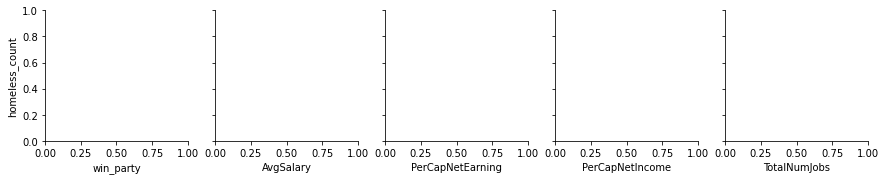

In [36]:
g_16 = sns.pairplot(df_econ_politcs.query("year == 2016"), 
             x_vars=["win_party","AvgSalary","PerCapNetEarning", "PerCapNetIncome", "TotalNumJobs"],
             y_vars=["homeless_count"])

g_16.fig.suptitle('Correlation between each variable and homeless count in 2016', fontsize = 15)
g_16.fig.tight_layout()

Text(0.5, 1.0, 'Correlation Heatmap for 2008')

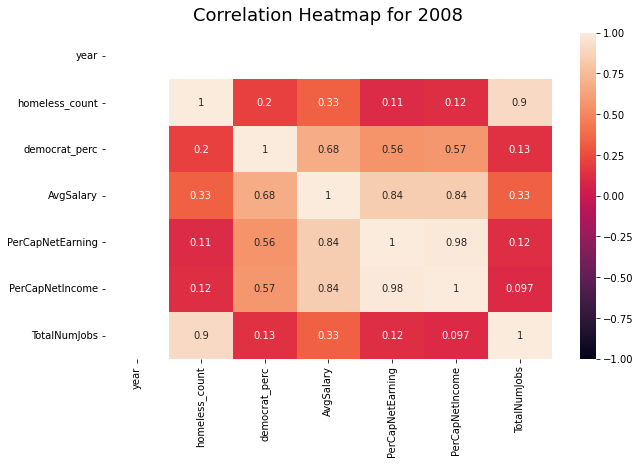

In [38]:
plt.figure(figsize=(10, 6))
heatmap_08 = sns.heatmap(df_econ_politcs.query("year == 2008").corr(), vmin=-1, vmax=1, annot=True)
heatmap_08.set_title('Correlation Heatmap for 2008', fontdict={'fontsize':18}, pad=12)

Text(0.5, 1.0, 'Correlation Heatmap for 2016')

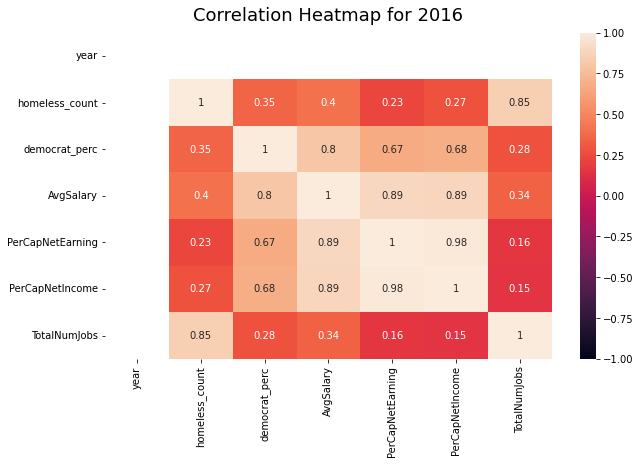

In [39]:
plt.figure(figsize=(10, 6))
heatmap_16 = sns.heatmap(df_econ_politcs.query("year == 2016").corr(), vmin=-1, vmax=1, annot=True)
heatmap_16.set_title('Correlation Heatmap for 2016', fontdict={'fontsize':18}, pad=12)

## <a id='toc2_8_'></a>[Choropleth graph of homeless count by state](#toc0_)

In [40]:
fig = px.choropleth(df_econ_politcs.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='homeless_count',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Homeless Count by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

In [41]:
fig = px.choropleth(df_econ_politcs.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='homeless_count',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Homeless Count by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

## <a id='toc2_9_'></a>[Choropleth graph of political party by state](#toc0_)

In [42]:
color_scale = {'Republican': 'red', 'Democrat': 'blue'}


fig = px.choropleth(df_econ_politcs.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='win_party',
                    color_discrete_map=color_scale, 
                    )

fig.update_layout(
      title_text = 'Political Party by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['year', 'state_abbrev', 'homeless_count', 'democrat_perc', 'AvgSalary', 'PerCapNetEarning', 'PerCapNetIncome', 'TotalNumJobs'] but received: win_party

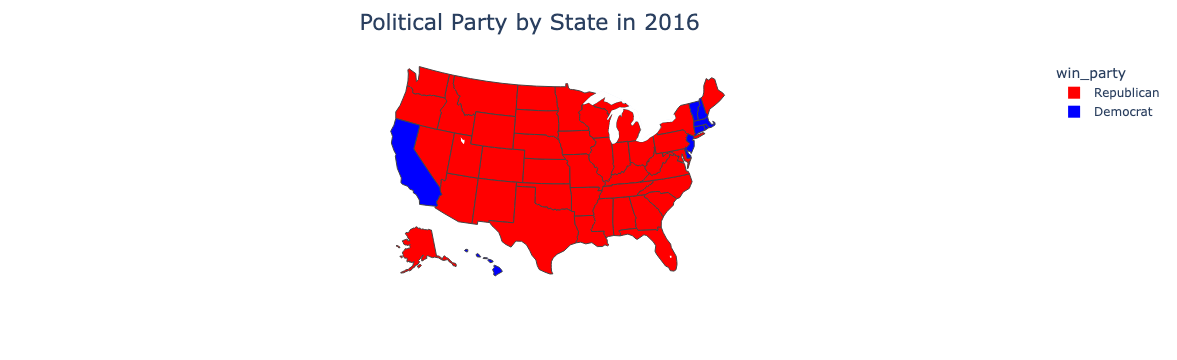

In [ ]:
color_scale = {'Republican': 'red', 'Democrat': 'blue'}


fig = px.choropleth(df_econ_politcs.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='win_party',
                    color_discrete_map=color_scale, 
                    )

fig.update_layout(
      title_text = 'Political Party by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

## <a id='toc2_10_'></a>[Choropleth graph of average salary by state](#toc0_)

In [43]:
df_econ_politcs.columns

Index(['year', 'state_abbrev', 'homeless_count', 'democrat_perc', 'AvgSalary',
       'PerCapNetEarning', 'PerCapNetIncome', 'TotalNumJobs'],
      dtype='object')

In [44]:
fig = px.choropleth(df_econ_politcs.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='AvgSalary',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Average Salary by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

In [45]:
fig = px.choropleth(df_econ_politcs.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='AvgSalary',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Average Salary by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

## <a id='toc2_11_'></a>[Choropleth graph of per capita net earning by state](#toc0_)

In [46]:
df_econ_politcs.columns

Index(['year', 'state_abbrev', 'homeless_count', 'democrat_perc', 'AvgSalary',
       'PerCapNetEarning', 'PerCapNetIncome', 'TotalNumJobs'],
      dtype='object')

In [47]:
fig = px.choropleth(df_econ_politcs.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='PerCapNetEarning',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Per Capita Net Earning by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

In [48]:
fig = px.choropleth(df_econ_politcs.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='PerCapNetEarning',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Per Capita Net Earning by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

## <a id='toc2_12_'></a>[Choropleth graph of Total Number of Jobs by state](#toc0_)

In [49]:
fig = px.choropleth(df_econ_politcs.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='TotalNumJobs',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Total Number of Jobs by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

In [50]:
fig = px.choropleth(df_econ_politcs.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='TotalNumJobs',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Total Number of Jobs by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

# <a id='toc3_'></a>[Model Development and Evaluation](#toc0_)

In [51]:
ecopolitics = pd.read_csv("../data/homeless_count_Econ_Politics_by_state.csv")
ecopolitics.rename(columns={"state_abbrev": "state"},inplace=True)
ecopolitics

,year,state,homeless_count,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs
0,2008,AK,7462.0,37.889374,48527.0,31586.0,47749.0,443538.0
1,2008,AL,23652.0,38.740434,38138.0,20229.0,33353.0,2582591.0
2,2008,AR,14806.0,38.864660,35310.0,18526.0,31940.0,1579283.0
3,2008,AZ,56146.0,45.115251,43311.0,22318.0,35563.0,3402808.0
4,2008,CA,626632.0,61.012638,52524.0,28770.0,43890.0,20654292.0
...,...,...,...,...,...,...,...,...
103,2016,VT,5762.0,56.675987,44188.0,29569.0,50420.0,433924.0
104,2016,WA,103862.0,54.303577,58989.0,34596.0,55802.0,4310119.0
105,2016,WI,27656.0,46.436079,46551.0,30320.0,47598.0,3658030.0
106,2016,WV,7020.0,26.476928,41183.0,20587.0,37099.0,890105.0


In [52]:
housingprice = pd.read_csv("../data/homeless_count_with_housing_price_by_state.csv")
housingprice.rename(columns={"Year_only": "year"},inplace=True)
housingprice

,year,state_abbrev,homeless_count,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,2008,AK,7462,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,AL,23652,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,AR,14806,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,AZ,56146,190750.000000,NaN,NaN,NaN,NaN,NaN
4,2008,CA,626632,314980.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
103,2016,VT,5762,NaN,152.405230,146.871426,140.774273,138.816947,121.721618
104,2016,WA,103862,294916.666667,270.179354,192.746052,174.273438,174.817988,183.988193
105,2016,WI,27656,163283.333333,139.400275,119.647646,119.108371,113.191737,98.356697
106,2016,WV,7020,140341.666667,111.100490,81.744695,90.590600,93.592909,89.201195


In [53]:
combined = pd.concat([ecopolitics, housingprice.drop(columns=['year', 'state_abbrev','homeless_count'])], axis=1, join="inner")
combined

,year,state,homeless_count,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,2008,AK,7462.0,37.889374,48527.0,31586.0,47749.0,443538.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,AL,23652.0,38.740434,38138.0,20229.0,33353.0,2582591.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,AR,14806.0,38.864660,35310.0,18526.0,31940.0,1579283.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,AZ,56146.0,45.115251,43311.0,22318.0,35563.0,3402808.0,190750.000000,NaN,NaN,NaN,NaN,NaN
4,2008,CA,626632.0,61.012638,52524.0,28770.0,43890.0,20654292.0,314980.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2016,VT,5762.0,56.675987,44188.0,29569.0,50420.0,433924.0,NaN,152.405230,146.871426,140.774273,138.816947,121.721618
104,2016,WA,103862.0,54.303577,58989.0,34596.0,55802.0,4310119.0,294916.666667,270.179354,192.746052,174.273438,174.817988,183.988193
105,2016,WI,27656.0,46.436079,46551.0,30320.0,47598.0,3658030.0,163283.333333,139.400275,119.647646,119.108371,113.191737,98.356697
106,2016,WV,7020.0,26.476928,41183.0,20587.0,37099.0,890105.0,140341.666667,111.100490,81.744695,90.590600,93.592909,89.201195


In [54]:
# Categorical variables: state_abbrev (use one-hot encoding later)
enc = OrdinalEncoder()
# enc = OneHotEncoder(handle_unknown='ignore')
combined['state'] = enc.fit_transform(combined[['state']])

# Categorical variables: win_party
# combined['win_party'] = [1 if i == 'Democrat' else 0 for i in combined['win_party']]

combined

,year,state,homeless_count,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,2008,0.0,7462.0,37.889374,48527.0,31586.0,47749.0,443538.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,1.0,23652.0,38.740434,38138.0,20229.0,33353.0,2582591.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,2.0,14806.0,38.864660,35310.0,18526.0,31940.0,1579283.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,3.0,56146.0,45.115251,43311.0,22318.0,35563.0,3402808.0,190750.000000,NaN,NaN,NaN,NaN,NaN
4,2008,4.0,626632.0,61.012638,52524.0,28770.0,43890.0,20654292.0,314980.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2016,49.0,5762.0,56.675987,44188.0,29569.0,50420.0,433924.0,NaN,152.405230,146.871426,140.774273,138.816947,121.721618
104,2016,50.0,103862.0,54.303577,58989.0,34596.0,55802.0,4310119.0,294916.666667,270.179354,192.746052,174.273438,174.817988,183.988193
105,2016,51.0,27656.0,46.436079,46551.0,30320.0,47598.0,3658030.0,163283.333333,139.400275,119.647646,119.108371,113.191737,98.356697
106,2016,52.0,7020.0,26.476928,41183.0,20587.0,37099.0,890105.0,140341.666667,111.100490,81.744695,90.590600,93.592909,89.201195


## <a id='toc3_1_'></a>[Impute missing data](#toc0_)

In [55]:
# kNN imputer
knn_imp = KNNImputer(n_neighbors=5)
imputed = pd.DataFrame(knn_imp.fit_transform(combined))
imputed.columns = combined.columns
imputed

,year,state,homeless_count,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,2008.0,0.0,7462.0,37.889374,48527.0,31586.0,47749.0,443538.0,231598.000000,189.010261,155.750933,149.037258,148.869795,147.087177
1,2008.0,1.0,23652.0,38.740434,38138.0,20229.0,33353.0,2582591.0,170557.666667,148.498418,124.463102,125.439907,132.672515,133.530986
2,2008.0,2.0,14806.0,38.864660,35310.0,18526.0,31940.0,1579283.0,167393.333333,124.030313,93.902470,102.908534,114.327512,115.608925
3,2008.0,3.0,56146.0,45.115251,43311.0,22318.0,35563.0,3402808.0,190750.000000,188.994777,156.591029,151.775536,152.915434,154.119572
4,2008.0,4.0,626632.0,61.012638,52524.0,28770.0,43890.0,20654292.0,314980.000000,208.069261,158.420823,146.215846,152.430638,160.305918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2016.0,49.0,5762.0,56.675987,44188.0,29569.0,50420.0,433924.0,231598.000000,152.405230,146.871426,140.774273,138.816947,121.721618
104,2016.0,50.0,103862.0,54.303577,58989.0,34596.0,55802.0,4310119.0,294916.666667,270.179354,192.746052,174.273438,174.817988,183.988193
105,2016.0,51.0,27656.0,46.436079,46551.0,30320.0,47598.0,3658030.0,163283.333333,139.400275,119.647646,119.108371,113.191737,98.356697
106,2016.0,52.0,7020.0,26.476928,41183.0,20587.0,37099.0,890105.0,140341.666667,111.100490,81.744695,90.590600,93.592909,89.201195


In [56]:
# exclude the state
imputed = imputed.drop(columns = "state")
imputed

,year,homeless_count,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,2008.0,7462.0,37.889374,48527.0,31586.0,47749.0,443538.0,231598.000000,189.010261,155.750933,149.037258,148.869795,147.087177
1,2008.0,23652.0,38.740434,38138.0,20229.0,33353.0,2582591.0,170557.666667,148.498418,124.463102,125.439907,132.672515,133.530986
2,2008.0,14806.0,38.864660,35310.0,18526.0,31940.0,1579283.0,167393.333333,124.030313,93.902470,102.908534,114.327512,115.608925
3,2008.0,56146.0,45.115251,43311.0,22318.0,35563.0,3402808.0,190750.000000,188.994777,156.591029,151.775536,152.915434,154.119572
4,2008.0,626632.0,61.012638,52524.0,28770.0,43890.0,20654292.0,314980.000000,208.069261,158.420823,146.215846,152.430638,160.305918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2016.0,5762.0,56.675987,44188.0,29569.0,50420.0,433924.0,231598.000000,152.405230,146.871426,140.774273,138.816947,121.721618
104,2016.0,103862.0,54.303577,58989.0,34596.0,55802.0,4310119.0,294916.666667,270.179354,192.746052,174.273438,174.817988,183.988193
105,2016.0,27656.0,46.436079,46551.0,30320.0,47598.0,3658030.0,163283.333333,139.400275,119.647646,119.108371,113.191737,98.356697
106,2016.0,7020.0,26.476928,41183.0,20587.0,37099.0,890105.0,140341.666667,111.100490,81.744695,90.590600,93.592909,89.201195


In [57]:
X = imputed.drop(columns='homeless_count')
y = imputed['homeless_count']

# Shuffle

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [58]:
list(X.columns)

['year',
 'democrat_perc',
 'AvgSalary',
 'PerCapNetEarning',
 'PerCapNetIncome',
 'TotalNumJobs',
 'Sale_Prices',
 'MedianListingPricePerSqft_1Bedroom',
 'MedianListingPricePerSqft_2Bedroom',
 'MedianListingPricePerSqft_3Bedroom',
 'MedianListingPricePerSqft_4Bedroom',
 'MedianListingPricePerSqft_5BedroomOrMore']

In [59]:
predictor = 'TotalNumJobs'
baseline_linreg = LinearRegression().fit(X_train[predictor].values.reshape(-1,1), y_train)

In [60]:
#Predict
y_pred_train = baseline_linreg.predict(X_train[predictor].values.reshape(-1,1))
y_pred_test = baseline_linreg.predict(X_test[predictor].values.reshape(-1,1))

#Compute the MSE of the model
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred_test)
base_model_r2 = r2_score(y_test, y_pred_test)

print("Linear regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTest R-squared\t{base_model_r2:.4f}")

Linear regression model results:

	Train MSE	1761148283.7762
	Test MSE	4780956885.6350

	Test R-squared	0.2936


In [61]:
baseline_model_slope =baseline_linreg.coef_
baseline_model_intercept = baseline_linreg.intercept_

baseline_model_params = [baseline_linreg.intercept_, *baseline_linreg.coef_]
baseline_model_params_df = pd.DataFrame(baseline_model_params, columns = ["Coefficient"], index=["intercept"]+[str(i) for i in [predictor]])
baseline_model_params_df

,Coefficient
intercept,-30488.261199
TotalNumJobs,0.023848


## <a id='toc3_2_'></a>[Plotting](#toc0_)

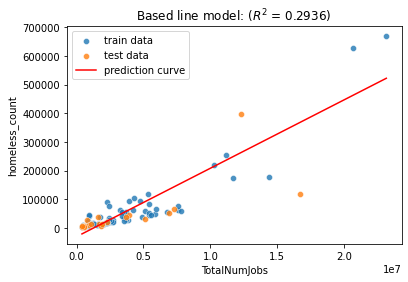

In [62]:
#Preliminary plotting
x_lin = np.linspace(min(X_train[predictor].values), max(X_train[predictor].values), 1000).reshape(-1, 1)

# split the x and y coords for plotting
pred_curve_y = [i*baseline_model_slope[0] + baseline_model_intercept for i in x_lin]

sns.scatterplot(data=imputed,x=X_train[predictor],y=y_train,alpha=0.8, label="train data")
sns.scatterplot(data=imputed,x=X_test[predictor],y=y_test,alpha=0.8, label="test data")
plt.plot(x_lin, pred_curve_y, label = f"prediction curve", c='red')
plt.title(f"Based line model: ($R^2$ = {base_model_r2:.4f})")
plt.legend();

# <a id='toc4_'></a>[Standardize the data](#toc0_)

Here we standardize our data for training different models by each member. 

In [63]:
scaler = StandardScaler()
imputed_scaled = scaler.fit_transform(imputed)
imputed_scaled = pd.DataFrame(imputed_scaled, columns=imputed.columns)
imputed_scaled
X_scaled = imputed_scaled.drop(columns='homeless_count')
y_scaled = imputed_scaled['homeless_count']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=300) # set seed for reproducibility

In [64]:
X_train.to_csv("../data/scaled_X_train.csv", index=False)
X_test.to_csv("../data/scaled_X_test.csv", index=False)
y_train.to_csv("../data/scaled_y_train.csv", index=False)
y_test.to_csv("../data/scaled_y_test.csv", index=False)